In [1]:
import warnings
warnings.filterwarnings('ignore')

In [231]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, plot_confusion_matrix,roc_auc_score, roc_curve, auc
from imblearn.metrics import classification_report_imbalanced

## Pre-Modeling

#### Assemble the data

##### Data available after preprocessing: [Resources](https://github.com/Marwan-Takrouri/Human-or-Robot-Facebook-Kaggle/tree/main/Resources_for_modeling)
- bidders.csv: groupby bidder_id, then count unique value of auctions, merchandise, device, country, ip, url, timediff for each bidder, and the highest order rank and total number of bids the bidder participated. Last are the mean, sd of timediff.  
- bidder_encoding.csv: groupby bidder_id, then encode device, country and merchandis.
- bidder_auc.csv: groupby bidder_id and auction, then count unique value of  merchandise, device, country, ip, url, timediff for each bidder, and the highest order rank and total number of bids the bidder participated in corresponding auction. Last are the mean, sd of timediff.

In [3]:
bidders = pd.read_csv("./Resources/bidders.csv", index_col =False)
bidder_encoding = pd.read_csv("./Resources/bidder_encoding.csv", index_col =False)
bidder_auc = pd.read_csv("./Resources/bidder_auc.csv")
train = pd.read_csv("./Resources/train.csv")

bidders = bidders.merge(bidder_encoding, right_index=True, left_index=True)
# bidders = bidders.merge(bidder_auc, right_index=True, left_index=True)

print(bidders.shape)
bidders.head()

(6614, 52)


,bidder_id,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,timediff_count,bidder_rank_min,bid_count,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,001068c415025a009fee375a12cff4fcnht8y,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1899.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,002d229ffb247009810828f648afc2ef593rb,1.0,1.0,2.0,1.0,1.0,1.0,1.0,51.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0030a2dd87ad2733e0873062e4f83954mkj86,1.0,1.0,1.0,1.0,1.0,1.0,0.0,23448.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3.0,1.0,3.0,1.0,3.0,2.0,2.0,121.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00486a11dff552c4bd7696265724ff81yeo9v,13.0,1.0,8.0,1.0,10.0,7.0,19.0,62.0,20.0,...,0.0,0.0,0.0,0.0,0.0,2.0,7.0,5.0,0.0,2.0


Since in [Explore the data](https://github.com/Marwan-Takrouri/Human-or-Robot-Facebook-Kaggle/blob/main/Explore_the_data.ipynb) we found the bidders who never bid are all human, just ignore them with inner join 

In [4]:
# merged_bidders = train.merge(bidders, how= "left", on="bidder_id")
 
merged_bidders = train.merge(bidders, how= "inner", on="bidder_id")
# merged_bidders = train.merge(bidder_auc, how= "inner", on="bidder_id")

print(merged_bidders.shape)
merged_bidders.head()

(1984, 55)


,bidder_id,payment_account,address,outcome,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,18.0,1.0,14.0,6.0,20.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,1.0,1.0,2.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,1.0,2.0,1.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,23.0,1.0,53.0,2.0,123.0,91.0,...,1.0,1.0,7.0,0.0,11.0,1.0,19.0,5.0,0.0,0.0


Since each bidder in train dataset has corresponding unique payment account and address, and bidder_id is also a unique id that won't be useful for machine lerning. <br>
These three columns could be dropped.

In [5]:
m_bidders = merged_bidders.drop(columns=["payment_account", "address"])
# merged_bidders = merged_bidders.drop(columns=["auction"])

print(m_bidders.shape)
m_bidders.head()

(1984, 53)


,bidder_id,outcome,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,timediff_count,bidder_rank_min,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,18.0,1.0,14.0,6.0,20.0,1.0,23.0,5.0,...,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,0.0,1.0,1.0,2.0,1.0,3.0,2.0,2.0,73166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0,4.0,1.0,2.0,1.0,4.0,2.0,3.0,396.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1395.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0,23.0,1.0,53.0,2.0,123.0,91.0,143.0,4.0,...,1.0,1.0,7.0,0.0,11.0,1.0,19.0,5.0,0.0,0.0


In [6]:
human = m_bidders.loc[m_bidders["outcome"] == 1]
human

,bidder_id,outcome,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,timediff_count,bidder_rank_min,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
21,5354c02817e47f28e60e44a40ca5e48dll4sz,1.0,18.0,1.0,51.0,7.0,13.0,1.0,157.0,83.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,27.0
49,9434778d2268f1fa2a8ede48c0cd05c097zey,1.0,269.0,1.0,408.0,67.0,3455.0,1916.0,735.0,1.0,...,7.0,132.0,25.0,7.0,541.0,111.0,409.0,44.0,37.0,100.0
50,aabc211b4cf4d29e4ac7e7e361371622pockb,1.0,127.0,1.0,24.0,14.0,358.0,5.0,804.0,1.0,...,0.0,0.0,0.0,856.0,0.0,0.0,0.0,0.0,0.0,0.0
57,68d468e15e0de0bab9694cdca8e799eb2j8kn,1.0,26.0,1.0,1.0,2.0,8.0,7.0,60.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,281.0,0.0
76,1cbd9081de4481ada66f1853737f7684ddjd1,1.0,107.0,1.0,4.0,29.0,836.0,4.0,600.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,899.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1907,458c8c4e10e5c1b29e3fbe5ee56d46e8y3fb3,1.0,103.0,1.0,166.0,37.0,414.0,845.0,600.0,1.0,...,10.0,13.0,4.0,232.0,13.0,0.0,15.0,6.0,7.0,23.0
1913,022ac3a7ce986049d9a4bede83ccf9ddctvg6,1.0,85.0,1.0,18.0,7.0,32.0,2.0,204.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0
1939,6c11cc7744fb52a632306ca8bf966cd1e4zxx,1.0,100.0,1.0,164.0,30.0,414.0,363.0,453.0,2.0,...,19.0,13.0,8.0,48.0,3.0,1.0,27.0,2.0,0.0,44.0
1941,17a321c4a0d925ca80507effa52330ac5n5r7,1.0,509.0,1.0,376.0,72.0,1159.0,325.0,898.0,1.0,...,22.0,85.0,14.0,130.0,55.0,12.0,39.0,9.0,10.0,53.0


In [133]:
human.to_csv("./Resources/huamn.csv", index=False)

In [134]:
robots = m_bidders.loc[m_bidders["outcome"] == 0]
robots

,bidder_id,outcome,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,timediff_count,bidder_rank_min,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,18.0,1.0,14.0,6.0,20.0,1.0,23.0,5.0,...,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,0.0,1.0,1.0,2.0,1.0,3.0,2.0,2.0,73166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0,4.0,1.0,2.0,1.0,4.0,2.0,3.0,396.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1395.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0,23.0,1.0,53.0,2.0,123.0,91.0,143.0,4.0,...,1.0,1.0,7.0,0.0,11.0,1.0,19.0,5.0,0.0,0.0
5,7eaefc97fbf6af12e930528151f86eb91bafh,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,24530.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,25558d24bca82beef0f9db4ba1fe2045ynnvq,0.0,8.0,1.0,2.0,1.0,3.0,8.0,7.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,88ae7a35e374a6fddd079ebb28c822eeohwse,0.0,10.0,1.0,3.0,3.0,32.0,1.0,33.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0
8,57db69e32163f3e486dc6ef7d615aa12usje6,0.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,976.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,d1be739798ba0745a1fd72ac918a9f1929hei,0.0,10.0,1.0,11.0,5.0,12.0,7.0,13.0,546.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0


In [135]:
robots.to_csv("./Resources/robots.csv", index=False)

In [7]:
merged_bidders = merged_bidders.drop(columns=["bidder_id","payment_account", "address"])
# merged_bidders = merged_bidders.drop(columns=["auction"])

print(merged_bidders.shape)
merged_bidders.head()

(1984, 52)


,outcome,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,timediff_count,bidder_rank_min,bid_count,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,0.0,18.0,1.0,14.0,6.0,20.0,1.0,23.0,5.0,24.0,...,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0
1,0.0,1.0,1.0,2.0,1.0,3.0,2.0,2.0,73166.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,1.0,2.0,1.0,4.0,2.0,3.0,396.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1395.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,23.0,1.0,53.0,2.0,123.0,91.0,143.0,4.0,155.0,...,1.0,1.0,7.0,0.0,11.0,1.0,19.0,5.0,0.0,0.0


Total bids made by robots: 103
Total bids made by human:  1881


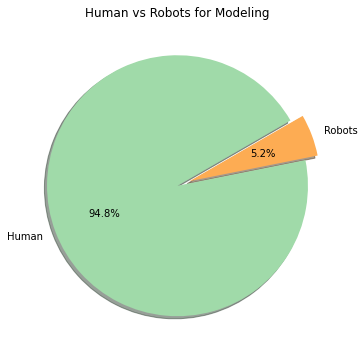

In [8]:
# Human and Robot distribution
print(f"Total bids made by robots: {len(merged_bidders[merged_bidders['outcome'] == 1])}")
print(f"Total bids made by human:  {len(merged_bidders[merged_bidders['outcome'] == 0])}")

x = merged_bidders.outcome.value_counts()

plt.subplots(figsize=(10, 6))
plt.pie(x, labels=["Human", "Robots"], colors=["#A0DAA9", "#FDAC53"],explode=[0, 0.1], autopct='%1.1f%%', shadow=True,startangle=30)
plt.title("Human vs Robots for Modeling")
mpl.rcParams['font.size'] = 14
plt.savefig("Images/human_bot_modeling.png")
plt.show()

Still a severely imbalanced dataset. Therefore we will choose models fit imbalanced data.

In [45]:
# merged_bidders.to_csv("./Resources/merged_bidders.csv", index=False)

In [232]:
model_data = merged_bidders.copy()

In [233]:
# Feature selection, drop unrelated features if necessary
# columns_to_drop = []
# model_data.drop(columns_to_drop, axis=1, inplace=True)
# print(model_data.shape)
# model_data.head()

#### Spilt and scale the data

In [234]:
# Split our preprocessed data into features and target arrays
y = model_data["outcome"].values
X = model_data.drop(columns= "outcome", axis= 1).values

# Split the preprocessed data into a training and testing dataset
# Default
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Customize the split size
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.8)

In [235]:
# Create a Scaler instances: Try two scaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#### Balanced RandomForest Classifier

In [236]:
from imblearn.ensemble import BalancedRandomForestClassifier
start_time = time.time()
model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
brf_time = time.time() - start_time
print(f"Processing time: {brf_time} seconds")

Processing time: 0.275296688079834 seconds


Accuracy Score: 0.8872340425531915
Confusion Matrix


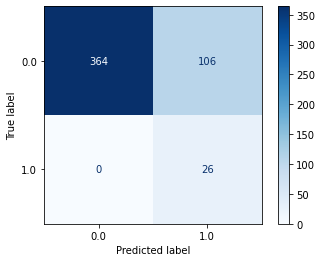

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.77      1.00      0.87      0.88      0.76       470
        1.0       0.20      1.00      0.77      0.33      0.88      0.79        26

avg / total       0.96      0.79      0.99      0.84      0.88      0.76       496



In [237]:
brf_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {brf_acc}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test_scaled, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

ROC AUC: 0.8872340425531915


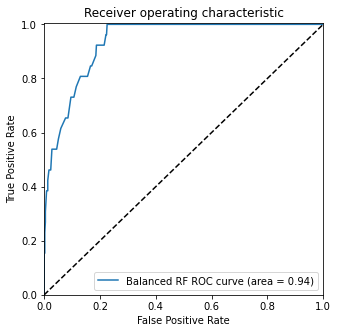

In [239]:
y_brf_score = model.predict_proba(X_test_scaled)[:, 1]
fpr_brf, tpr_brf, _brf = roc_curve(y_test, y_brf_score)
roc_brf_auc = auc(fpr_brf, tpr_brf)
brf_roc_auc_score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {brf_roc_auc_score}")

plt.figure(figsize=(5, 5))
plt.plot(fpr_brf, tpr_brf, label='Balanced RF ROC curve (area = %0.2f)' % roc_brf_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Images/roc_brf_auc.png')
plt.show()

In [240]:
# List the features sorted in descending order by feature importance
x = merged_bidders.drop(columns= "outcome", axis= 1)
import_score = model.fit(X_train_scaled, y_train).feature_importances_
import_rank = sorted(zip(import_score, x.columns), reverse=True)
importances = pd.DataFrame(import_rank, columns=["Feature Score", "Features"])
importances = importances[["Features", "Feature Score"]]
importances.index = np.arange(1, len(importances)+1)
importances.head()

,Features,Feature Score
1,time_mean,0.146199
2,time_median,0.088348
3,device_Others,0.087834
4,bid_count,0.071759
5,country_Others,0.051738


In [59]:
# Save data
# importances.to_csv("./Resources/importances.csv")

In [241]:
# Get the top 10 importances
top_10 = importances.head(10)
top_10

,Features,Feature Score
1,time_mean,0.146199
2,time_median,0.088348
3,device_Others,0.087834
4,bid_count,0.071759
5,country_Others,0.051738
6,bidder_rank_min,0.051117
7,time_std,0.036343
8,timediff_count,0.033584
9,device_phone65,0.031797
10,country_id,0.027021


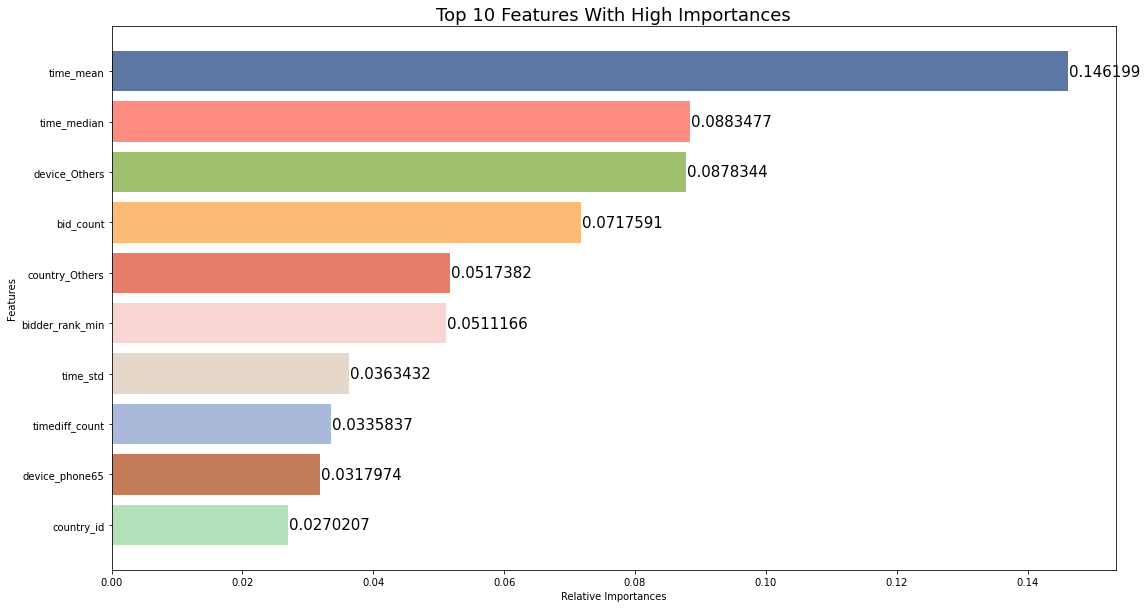

In [242]:
# Plot the importances
fig, ax = plt.subplots(figsize=(18,10))

x_value = top_10["Features"]
y_value = top_10["Feature Score"].values

color = ["#34568B", "#FF6F61", "#88B04B", "#FDAC53", "#E15D44", "#F7CAC9", "#DFCFBE", "#92A8D1", "#B55A30", "#A0DAA9"]
top10_plot = plt.barh(x_value, y_value, color = color, alpha=0.8)
plt.ylabel("Features")
plt.title("Top 10 Features With High Importances", fontsize=18)
plt.xlabel("Relative Importances")
ax.bar_label(top10_plot, padding=1, fontsize=15)
plt.gca().invert_yaxis()
plt.savefig("Images/Importances.png")
plt.show()

As can be seen in the graph above, a wide variety of  features emerge as significant in the Balanced RF model.

#### Easy Ensemble Classifier

In [243]:
from imblearn.ensemble import EasyEnsembleClassifier
start_time = time.time()
model = EasyEnsembleClassifier(n_estimators=200 ,random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
eec_time = time.time() - start_time
print(f"Processing time: {eec_time} seconds")

Processing time: 19.4730806350708 seconds


Accuracy Score: 0.782569558101473
Confusion Matrix


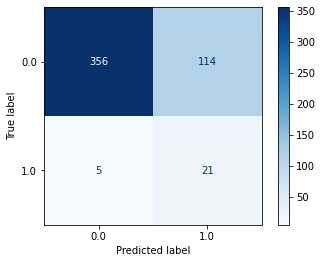

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.99      0.76      0.81      0.86      0.78      0.61       470
        1.0       0.16      0.81      0.76      0.26      0.78      0.61        26

avg / total       0.94      0.76      0.81      0.83      0.78      0.61       496



In [244]:
eec_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {eec_acc}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test_scaled, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

ROC AUC: 0.782569558101473


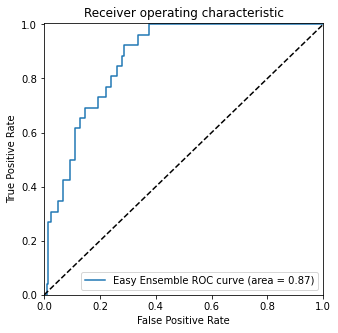

In [245]:
y_eec_score = model.predict_proba(X_test_scaled)[:, 1]
fpr_eec, tpr_eec, _eec = roc_curve(y_test, y_eec_score)
roc_eec_auc = auc(fpr_eec, tpr_eec)
eec_roc_auc_score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {eec_roc_auc_score}")

plt.figure(figsize=(5, 5))
plt.plot(fpr_eec, tpr_eec, label='Easy Ensemble ROC curve (area = %0.2f)' % roc_eec_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Images/roc_eec_auc.png')
plt.show()

#### Gradient Boosting Classifier

In [246]:
from sklearn.ensemble import GradientBoostingClassifier
start_time = time.time()
model = GradientBoostingClassifier(n_estimators=200, random_state= 42, max_depth=5)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
gbc_time = time.time() - start_time
print(f"Processing time: {gbc_time} seconds")

Processing time: 2.670936107635498 seconds


Accuracy Score: 0.6239770867430442
Confusion Matrix


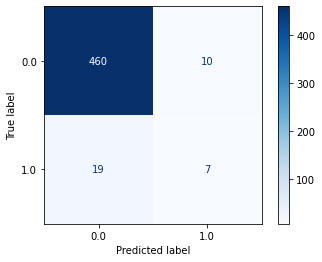

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.98      0.27      0.97      0.51      0.28       470
        1.0       0.41      0.27      0.98      0.33      0.51      0.24        26

avg / total       0.93      0.94      0.31      0.94      0.51      0.28       496



In [247]:
gbc_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {gbc_acc}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test_scaled, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

ROC AUC: 0.6239770867430442


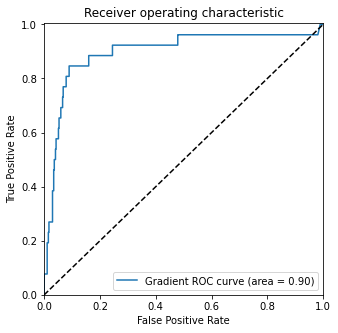

In [248]:
y_gbc_score = model.predict_proba(X_test_scaled)[:, 1]
fpr_gbc, tpr_gbc, _gbc = roc_curve(y_test, y_gbc_score)
roc_gbc_auc = auc(fpr_gbc, tpr_gbc)
gbc_roc_auc_score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {gbc_roc_auc_score}")

plt.figure(figsize=(5, 5))
plt.plot(fpr_gbc, tpr_gbc, label='Gradient ROC curve (area = %0.2f)' % roc_gbc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Images/roc_gbc_auc.png')
plt.show()

#### Ada Boost Classifier

In [249]:
from sklearn.ensemble import AdaBoostClassifier
start_time = time.time()
model = AdaBoostClassifier(n_estimators=300, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
abc_time = time.time() - start_time
print(f"Processing time: {abc_time} seconds")

Processing time: 1.3721818923950195 seconds


Accuracy Score: 0.6837970540098199
Confusion Matrix


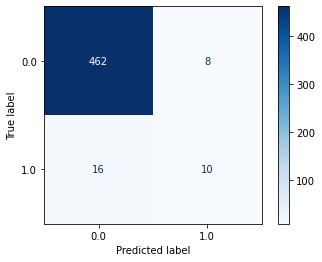

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.98      0.38      0.97      0.61      0.40       470
        1.0       0.56      0.38      0.98      0.45      0.61      0.36        26

avg / total       0.94      0.95      0.42      0.95      0.61      0.40       496



In [250]:
abc_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {abc_acc}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test_scaled, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

ROC AUC: 0.6837970540098199


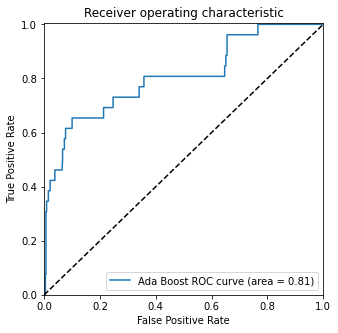

In [251]:
y_abc_score = model.predict_proba(X_test_scaled)[:, 1]
fpr_abc, tpr_abc, _abc = roc_curve(y_test, y_abc_score)
roc_abc_auc = auc(fpr_abc, tpr_abc)
abc_roc_auc_score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {abc_roc_auc_score}")

plt.figure(figsize=(5, 5))
plt.plot(fpr_abc, tpr_abc, label='Ada Boost ROC curve (area = %0.2f)' % roc_abc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Images/roc_abc_auc.png')
plt.show()

### Model Comparision

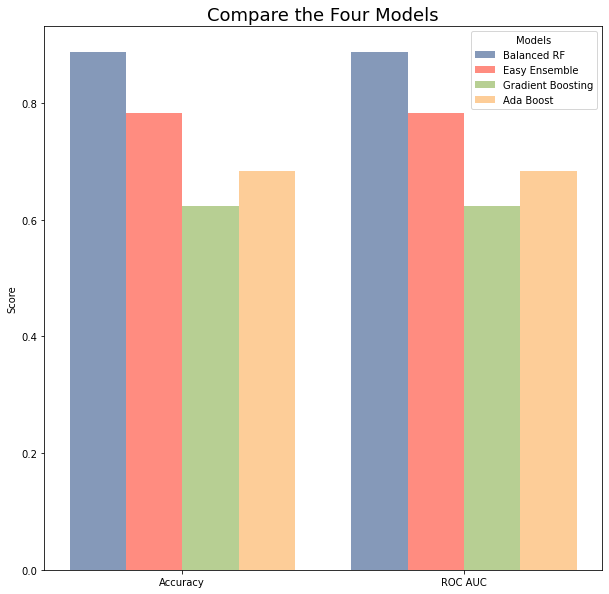

In [252]:
# Compare accuracy scores and ROC AUC scores
brf_metrics = [brf_acc, brf_roc_auc_score]
eec_metrics = [eec_acc, eec_roc_auc_score]
gbc_metrics = [gbc_acc, gbc_roc_auc_score]
abc_metrics = [abc_acc, abc_roc_auc_score]
labels = ["Accuracy", "ROC AUC"]

x_model = np.arange(len(labels)) 
width = 0.2
y_model_brf = [round(num, 4) for num in brf_metrics]
y_model_eec = [round(num, 4) for num in eec_metrics]
y_model_gbc = [round(num, 4) for num in gbc_metrics]
y_model_abc = [round(num, 4) for num in abc_metrics]

fig, ax1 = plt.subplots(figsize=(10,10))
comparision1 = plt.bar(x_model-2*width , y_model_brf, width, color = color[0], label="Balanced RF", alpha=0.6)
comparision2 = plt.bar(x_model-width , y_model_eec, width, color = color[1], label= "Easy Ensemble", alpha=0.8)
comparision3 = plt.bar(x_model , y_model_gbc, width, color = color[2], label= "Gradient Boosting", alpha=0.6)
comparision4 = plt.bar(x_model+width , y_model_abc, width, color = color[3], label= "Ada Boost", alpha=0.6)
plt.ylabel("Score")
plt.title("Compare the Four Models", fontsize=18)
plt.xticks(x_model-0.5*width, labels)
plt.legend(fontsize=10, title= "Models")
# plt.savefig("Images/model_comparision_scores.png", dpi=100)

plt.show()

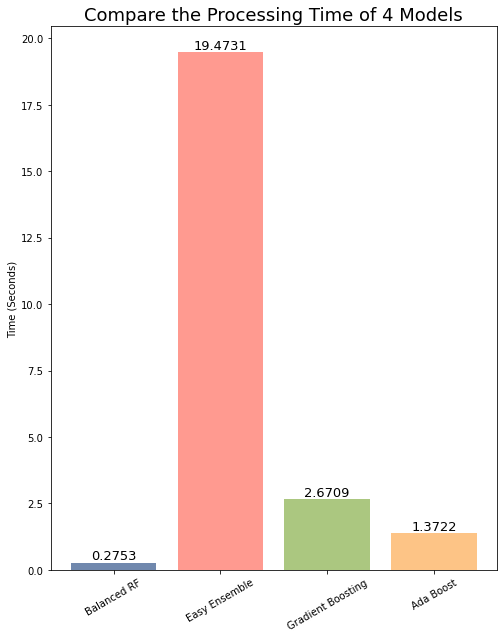

In [253]:
# Compare the processing time
model_time = [brf_time, eec_time, gbc_time, abc_time]
labels = ["Balanced RF", "Easy Ensemble", "Gradient Boosting", "Ada Boost"]
x_model = np.arange(len(labels)) 
y_model = [round(num, 4) for num in model_time]

fig, ax = plt.subplots(figsize=(8,10))
time_comparision = plt.bar(x_model , y_model, color = color, align="center", alpha=0.7)
plt.ylabel("Time (Seconds)")
plt.title("Compare the Processing Time of 4 Models", fontsize=18)
plt.xticks(x_model, labels)
ax.bar_label(time_comparision, fontsize=13)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="center")
# plt.savefig("Images/model_comparision_time.png", dpi=100)

plt.show()

Easy Ensemble Classifier has the highest score with fastest processing time, therefore we will use this model to train and predict the test data.

In [256]:
# Save the data
model_acc = [brf_acc, eec_acc, gbc_acc, abc_acc]
model_roc_auc = [brf_roc_auc_score, eec_roc_auc_score, gbc_roc_auc_score, abc_roc_auc_score]
labels = ["Balanced RF", "Easy Ensemble", "Gradient Boosting", "Ada Boost"]
model_comparision = pd.DataFrame({"Model": labels, "Time(s)": model_time, "Accuracy": model_acc, "ROC AUC": model_roc_auc})
model_comparision = model_comparision.round(4)
model_comparision
# model_comparision.to_csv("./Resources/model_comparision.csv")

### Submission

In [105]:
test = pd.read_csv("./Resources/test.csv")

In [106]:
merged_test = test.merge(bidders, how= "left", on="bidder_id")
merged_test.head()

,bidder_id,payment_account,address,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,timediff_count,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,a3d2de7675556553a5f08e4c88d2c228htx90,5d9fa1b71f992e7c7a106ce4b07a0a754le7c,3.0,1.0,2.0,3.0,4.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,a921612b85a1494456e74c09393ccb65ylp4y,a3d2de7675556553a5f08e4c88d2c228rs17i,a3d2de7675556553a5f08e4c88d2c228klidn,2.0,1.0,3.0,2.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6b601e72a4d264dab9ace9d7b229b47479v6i,925381cce086b8cc9594eee1c77edf665zjpl,a3d2de7675556553a5f08e4c88d2c228aght0,14.0,1.0,4.0,3.0,4.0,2.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,eaf0ed0afc9689779417274b4791726cn5udi,a3d2de7675556553a5f08e4c88d2c228nclv5,b5714de1fd69d4a0d2e39d59e53fe9e15vwat,90.0,1.0,81.0,14.0,129.0,80.0,145.0,...,6.0,1.0,0.0,0.0,4.0,1.0,20.0,0.0,1.0,0.0
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,a3d2de7675556553a5f08e4c88d2c228dtdkd,c3b363a3c3b838d58c85acf0fc9964cb4pnfa,20.0,1.0,17.0,2.0,17.0,1.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [107]:
test_id = merged_test["bidder_id"]

In [108]:
merged_test.fillna(merged_test.mean(), inplace=True)

In [109]:
y_train = model_data["outcome"].values
X_train = model_data.drop(columns= "outcome", axis= 1).values
X_test = merged_test.drop(columns=["bidder_id", "payment_account", "address"])

In [129]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)
X_test_scaled = MinMaxScaler().fit_transform(X_test)

In [145]:
model = BalancedRandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [146]:
submission = pd.read_csv("./Resources/sampleSubmission.csv")
result = pd.DataFrame({"bidder_id": test_id, "predicts": y_pred})
final_sub = submission.merge(result, on="bidder_id", how= "left")
final_sub = final_sub.drop(columns= "prediction", axis = 1)

In [118]:
final_sub["predicts"].value_counts()

0.0    3366
1.0    1334
Name: predicts, dtype: int64

In [119]:
final_sub.isnull().sum()

bidder_id    0
predicts     0
dtype: int64

In [147]:
final_sub.to_csv("Final_results.csv", index=False, header=["bidder_id", "prediction"])

This submission should score around 0.86563 on the private leaderboard for a rank of top 50%.